# Lesson 01: Electron Lifetime
### Dylan Temples 
June 17, 2019

The goal of this lesson is to illustrate the electron lifetime calibration and correction as performed in LXe-TPCs.

## Learning Objectives
Physics Topics:
- Energy deposition in LXe
- Electroluminesence gain
- Concepts of "cuts" and "corrections"

Programming Topics:
- Using git [?]
- Working with arrays (python slicing)
- Visualizing data with MatPlotLib
- Fitting data with SciPy Optimize

## Energy Deposition in Liquid Xenon
When ionizing radiation passes through liquid xenon (LXe), it causes the xenon atoms to produce scintillation photons and ionization electrons. Dual-phase xenon time-projection chambers (LXe-TPCs) use photodetectors (usually photomultiplier tubes, PMTs) to read out these signals.

If the average amount of energy required to produce a single quanta (one photon or one electron) is $W$, then the energy of a specific recoil in LXe is:
$$ E = W (n_\gamma + n_e ) $$
where $n_\gamma(n_e)$ is the number of photons(electrons) produced at the interaction site.

The scintillation photons are detected with imperfect efficiency in the PMTS and produce the S1 signal. We can paramterize this uncertainty with a gain factor $g_1$:
$$ n_\gamma = \frac{S1}{g_1} $$
with $0 \le g_1 \le 1$.

All the while, the electrons that were released at the interaction site experience a force due to the applied electric field:
$$ \mathbf{F}_e = (-e)\mathbf{E} = e E_0 \hat{\mathbf{z}} $$
and begin to drift upward to the liquid surface. Here they see a stronger electric field and are extracted into the gas phase, where they are accelerated until they are collected on the anode. While they accelerate, they produce secondary scintillation photons, this phenomenon is known as *electroluminesence*. These secondary scintillations photons produce the S2 signal which is proportional to the number of ionization electrons produced in the interaction.

Again we can parameterize this proportionality with a gain $g_2$:
$$ n_e = \frac{S2}{g_2} $$
where $g_2$ takes into account: the average number of photons produced per extrated electron and light collection efficiency in the gas phase.

With these two gain factors, we can write the energy deposited in the detector in terms of our observables:
$$ E = W \left( \frac{S1}{g_1} + \frac{S2}{g_2} \right) $$

## Electron Drift in LXe
The gain factor $g_2$ relies on the fact that every electron that was produced at the interaction site made it to the liquid surface and was extracted. In reality, it is not always true that every electron makes it to the liquid surface.

Impurities in the LXe (especially O$_2$ and N$_2$) can hold on to drifting electrons, and thus the number of electrons that are extracted $N_\mathrm{obs}$ is less than the number of electrons produced $N_e$. The concentration of impurities in the xenon determines the ratio of the two numbers. 

This means that as the electrons are traveling, there is some probability they are absorbed by impurities. You can define some scale length that is the most probable distance an electron will travel before it is absorbed. Since the electrons are drifting at a constant speed\*, we can turn this into a "lifetime" $\tau$.

This leads naturally to the concept of an exponential decay, where the number of electrons that make it to the liquid surface (the number you observe) is less than the number of electrons that were produced by a factor that scales exponentially with the amount of time the electrons are in the LXe:
$$ N_\mathrm{obs} = N_e e^{- t_\mathrm{drift} / \tau } $$

Thus at any given time, if you know the electron lifetime in the LXe, you can correct for the effects of the impurities:
$$ E = W \left( \frac{S1}{g_1} + \frac{S2_\mathrm{obs}e^{t_\mathrm{drift} / \tau}}{g_2} \right) $$

## Electron Lifetime Calibration
To be able to apply the above correction, one must know the electron lifetime. This can be found by doing a calibration with an internal, monoenergetic source ($^{83m}$Kr is typically used). The reason for this is you want the source to be homogenously distributed throughout your detector volume, most importantly uniform along $z$.

In the limit of perfectly pure LXe, the observed $S2$ size should only be a function of the energy deposited in the LXe, up to statistical fluctuations\*. Thus for a homogenously distributed monoenergetic source, you should see the same size $S2$ as a function of location in the detector.

But given the impurities in the xenon, what you observe is an S2 size that exponentially decays with depth in the detector. One can fit this decay to determine the electron lifetime.

## Git: How to get this file
The most common way of doing collaborative code development and version control is using git (ex: GitHub, GitLab). I have created a git repository that will be used for these lessons: https://github.com/dtemps123/HS_Lessons

To obtain your own copy of this repository, enter the following commands (note this is for Linux and Mac only, Windows users will need to figure it out themselves, though it is probably similar if not identical).

To copy the directory:

`git clone -b SIR_2020 https://github.com/dtemps123/HS_Lessons.git`

To create your own branch, first `cd` into the new directory, then run:

`git checkout -b <branch-name-here>`

`git push origin <branch-name-here>`

In this directory (`HS_Lessons/Lesson01`) you will notice a data file: `rawdaq_1901021108_parsed.dat`. This file contains reduced quantities from a data run that was processed using the XELDA data processing software. It is six columns of data: event ID, S1 pulse area, S2 pulse area, top-PMT-only S2 pulse area, drift time, radius-squared.

Once you have the repository cloned, you can start a Jupyter session by typing `jupyter notebook` in the terminal and following the generated link in a web browser.

## Visualizing the data
First we should import the libraries we think we will need and then we can open the data and start visualizing.

In [2]:
# -- Import the libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# -- Open the data
filename = "rawdaq_1901021108_parsed.dat"
data = np.loadtxt(filename, delimiter=",")

In [4]:
# -- Check the size of the data
n_cols = len(data[0,:])
print("The number of columns in the data is: "+str(n_cols))
for i in np.arange(n_cols):
    n_rows = len(data[:,i])
    print("The number of rows in column "+str(i)+" is: "+str(n_rows))

The number of columns in the data is: 6
The number of rows in column 0 is: 23826
The number of rows in column 1 is: 23826
The number of rows in column 2 is: 23826
The number of rows in column 3 is: 23826
The number of rows in column 4 is: 23826
The number of rows in column 5 is: 23826


The data has the number of columns we expect and has the same number of entries in each column, so we don't have to worry about jaggedness.

First, lets explicitly save our columns as one-dimensional arrays using the slice (`:`) operator. The slice operator takes all the entries along a specified axis.

In [5]:
# -- Save data as arrays
EvtID_array = data[:,0]  # first column
S1_array    = data[:,1]  # second column
S2_array    = data[:,2]  # third column
TS2_array   = data[:,3]  # fourth column
DT_array    = data[:,4]  # fifth column
R2_array    = data[:,5]  # sixth column

Now we can look at some of the data, for instance the distribution of drift times. To do the visualization we will use a histogram.

Text(0, 0.5, 'Counts per bin')

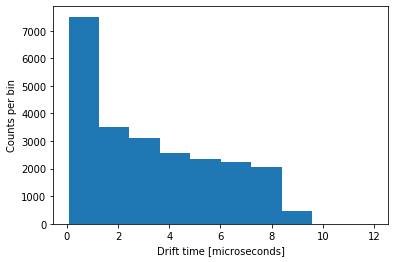

In [6]:
# -- Create a histogram of drift time
plt.figure(0)
plt.hist(DT_array)
plt.xlabel("Drift time [microseconds]")
plt.ylabel("Counts per bin")

Only basic quality and event-building "cuts" have been applied to these data. The major increase in rate is due to the geometry of our electric field. So let us limit the data to the region we are interested in: a drift time of 2.5 to 7.5 microseconds. We will also change our bin size.

To apply the drift time cut, we will use boolean statement to get the indeces of events that pass the cut.

[False  True False ... False False  True]


Text(0, 0.5, 'Counts per bin')

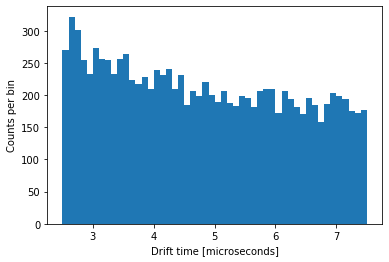

In [7]:
# -- Get array of T/F values for entries that meet our criteria
dt_cut_lims    = np.array([2.5, 7.5])
dt_cut_indexer = (DT_array >= dt_cut_lims[0]) * (DT_array <= dt_cut_lims[1])
print(dt_cut_indexer)

# -- Create the bins in drift time we want to use in the histogram
dt_step = 0.1    # microseconds
dt_bins = np.arange(start=dt_cut_lims[0], stop=dt_cut_lims[1]+dt_step, step=dt_step)

# -- Create a histogram of drift time
plt.figure(1)
plt.hist(DT_array[dt_cut_indexer], bins=dt_bins)
plt.xlabel("Drift time [microseconds]")
plt.ylabel("Counts per bin")

Now, let's look at S1 vs S2, with our drift time cut applied. Now we want to visualize the density of events along two axes, so we will use a two-dimensional histogram.

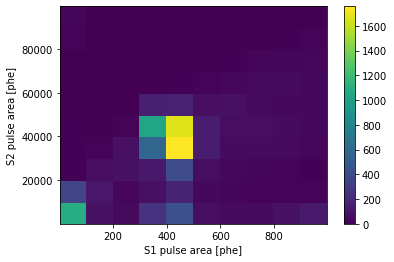

In [8]:
# -- Create a 2D histogram of S1 size vs S2 size
plt.figure(3)
h, xedges, yedges, img = plt.hist2d(S1_array[dt_cut_indexer],S2_array[dt_cut_indexer])
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("S2 pulse area [phe]")
plt.colorbar()

Pretty hard to see what's going on here, though you get the big picture: there are two blobs of events. Lets refine our binning and change the color scale so zero is white.

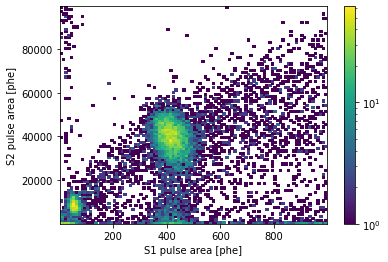

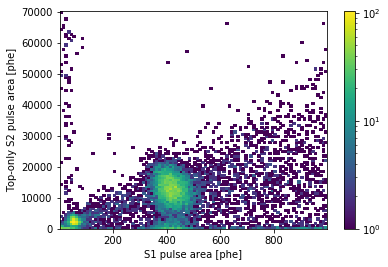

In [9]:
from matplotlib.colors import LogNorm
n_s1s2_bins = 100

# -- Create a 2D histogram of S1 size vs S2 size
plt.figure(3)
h, xedges, yedges, img = plt.hist2d(S1_array[dt_cut_indexer],S2_array[dt_cut_indexer], bins=n_s1s2_bins, norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("S2 pulse area [phe]")
plt.colorbar()

# -- Create a 2D histogram of S1 size vs Top-S2 size
plt.figure(4)
h, xedges, yedges, img = plt.hist2d(S1_array[dt_cut_indexer],TS2_array[dt_cut_indexer], bins=n_s1s2_bins, norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("Top-only S2 pulse area [phe]")
plt.colorbar()

Let's discuss what we're looking at.

## Electron Lifetime Effects
As discussed in the introduction of this lesson, impurities in the xenon will capture drifting electrons which induces an effective lifetime for the electrons, $\tau$. We will want to correct for this effect. To do so, we will use the $^{127}$Xe K-shell electron capture peak. Due to saturation effects of the bottom PMT, we will restrict ourselves to top-only S2 signals.

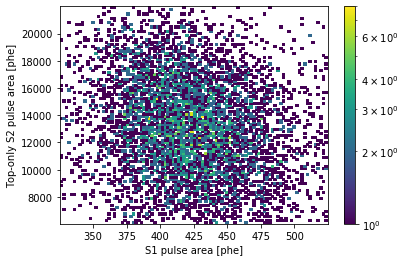

In [10]:
# -- Get array of T/F values for entries that meet our criteria
Kshell_s1_cut_lims     = np.array([325.0 , 525.0 ])
Kshell_ts2_cut_lims    = np.array([6.0e3 , 22.0e3])
Kshell_s1_cut_indexer  = (S1_array  >= Kshell_s1_cut_lims[0] ) * (S1_array  <= Kshell_s1_cut_lims[1] )
Kshell_ts2_cut_indexer = (TS2_array >= Kshell_ts2_cut_lims[0]) * (TS2_array <= Kshell_ts2_cut_lims[1])
Kshell_cut_indexer     = Kshell_s1_cut_indexer * Kshell_ts2_cut_indexer

ROI_cut_indexer = Kshell_cut_indexer * dt_cut_indexer

# -- Plot the K-Shell peak
plt.figure(5)
h, xedges, yedges, img = plt.hist2d(S1_array[ROI_cut_indexer],TS2_array[ROI_cut_indexer], bins=n_s1s2_bins, norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("Top-only S2 pulse area [phe]")
plt.colorbar()

This is the $^{127}$Xe $K$-shell electron capture peak. We will use the data in this plot to do our electron lifetime calibration.

For the purposes of this calibration, we are interested in the distribution of S2 sizes as a function of depth, or drift time. Just as we did to visualize one column of data, we can create a histogram in two dimensions to look at two columns of data.

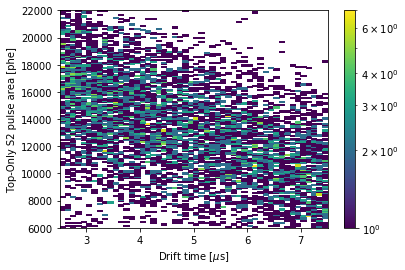

In [11]:
# -- First select our binning
ts2_step    = 100.    # phe
ts2_bins    = np.arange(start=Kshell_ts2_cut_lims[0], stop=Kshell_ts2_cut_lims[1]+ts2_step, step=ts2_step)
dt_ts2_bins = np.array([ dt_bins , ts2_bins ])

# -- Create a 2D histogram of S2 size vs drift time
plt.figure(6)
h, xedges, yedges, img = plt.hist2d(DT_array[ROI_cut_indexer],TS2_array[ROI_cut_indexer], bins=dt_ts2_bins, norm=LogNorm())
plt.xlabel(r"Drift time [$\mu$s]")
plt.ylabel("Top-Only S2 pulse area [phe]")
plt.colorbar()

What if we wanted to know the means and standard deviations of the S2 values in each drift time bin?

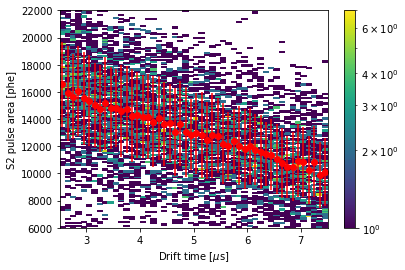

In [12]:
# -- Calculate mu, sigma of S2 for each DT bin
n_dt_bins      = len(dt_bins)-1
dt_bin_centers = (xedges[1:len(dt_bins)] + xedges[0:len(dt_bins)-1])/2.

means = np.zeros(n_dt_bins)
sdevs = np.zeros(len(dt_bin_centers))
for i in np.arange(len(dt_bin_centers)):
    indeces_of_bin = ROI_cut_indexer * (DT_array>=dt_bins[i]) * (DT_array<dt_bins[i+1])
    S2s_in_bin = TS2_array[indeces_of_bin]
    means[i] = np.mean(S2s_in_bin)
    sdevs[i] = np.std(S2s_in_bin)
    
# -- Plot them as errorbars on top of histogram
plt.figure(7)
plt.hist2d(DT_array[ROI_cut_indexer],TS2_array[ROI_cut_indexer], bins=dt_ts2_bins, norm=LogNorm())
plt.errorbar(dt_bin_centers, means, yerr=sdevs, fmt='o', color='r')
plt.xlabel(r"Drift time [$\mu$s]")
plt.ylabel("S2 pulse area [phe]")
plt.colorbar()

### Fitting data with Python
It would be useful if we could describe the trend of the red points using an analytical expression. To accomplish this, we can fit the data to an equation we specify. This uses the method of least squares to find parameters of the fit function that most closely match the data. We will see an example below.

First we have to define a fit function, we will start with a line.

In [13]:
def line_fit_eq(x, a, b):
     return a*x + b

Next, we import the required library.

In [14]:
from scipy.optimize import curve_fit

x_data = dt_bin_centers
y_data = means
y_errs = sdevs

popt_lin, pcov_lin = curve_fit(line_fit_eq, x_data, y_data)
perr_lin = np.sqrt(np.diag(pcov_lin))
fit_y_vals_lin = line_fit_eq(x_data, popt_lin[0], popt_lin[1])

print(popt_lin)
print(perr_lin)

[-1219.65677538 19135.2164349 ]
[ 23.10520101 120.24142911]


Now we can plot it on top of our data.

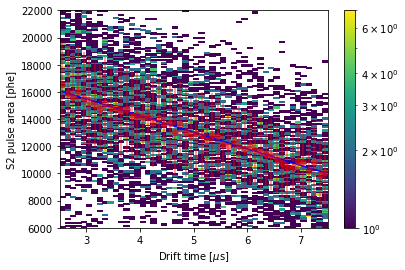

In [15]:
plt.figure(8)
plt.hist2d(DT_array[ROI_cut_indexer],TS2_array[ROI_cut_indexer], bins=dt_ts2_bins, norm=LogNorm())
plt.plot(x_data, fit_y_vals_lin, color='b', label="Best fit")
plt.errorbar(dt_bin_centers, means, yerr=sdevs, fmt='o', color='r', label=r"$\mu \pm\ sigma$", alpha=0.5)
plt.xlabel(r"Drift time [$\mu$s]")
plt.ylabel("S2 pulse area [phe]")
plt.colorbar()

# Assignment
The following exercises will take you through the electron lifetime calibration measurement and applying the correction to the data.

## Problem 1.
As discussed above, the S2 yield as a function of depth should follow an exponential distribution parameterized by the electron lifetime $\tau$, as follows
$$ S2_\text{obs} = S2 e^{-t_\mathrm{drift}/\tau} $$
Fit the data to an exponential function, and extract the electron lifetime, *with uncertainty!*

The electron lifetime is 10.705056972876482 +/- 0.21449590800238189 microseconds.


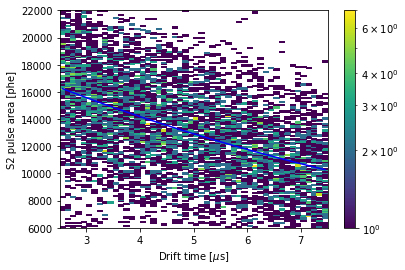

In [21]:
## Put your solution to problem 1 here.
## ANSWER = XX microseconds +/- YY microseconds
def exp_fit_eq(x, A, tau):
    return A * np.exp(-x / tau)

popt_exp, pcov_exp = curve_fit( f = exp_fit_eq, 
                        xdata = x_data,
                        ydata = y_data,
                        p0 = [50e3, 10.0]
                        )
perr_exp = np.sqrt(np.diag(pcov_exp))
fit_y_vals_exp = exp_fit_eq(x_data, popt_exp[0], popt_exp[1])

plt.figure(9)
plt.hist2d(DT_array[ROI_cut_indexer],TS2_array[ROI_cut_indexer], bins=dt_ts2_bins, norm=LogNorm())
plt.plot(x_data, fit_y_vals_exp, color='b', label="Best fit")
# plt.errorbar(dt_bin_centers, means, yerr=sdevs, fmt='o', color='r', label=r"$\mu \pm\ sigma$", alpha=0.5)
plt.xlabel(r"Drift time [$\mu$s]")
plt.ylabel("S2 pulse area [phe]")
plt.colorbar()

exp_lifetime = popt_exp[1]

print("The electron lifetime is " + str(popt_exp[1]) + " +/- " + str(perr_exp[1]) + " microseconds." )

## Problem 2.
Now that we have the electron lifetime in hand, we can correct all the observed S2 areas into the S2 area we would have observed if we had infinite electron lifetime. To do this, one needs to invert the exponential equation to solve for $S2$ in terms of $S2_\mathrm{obs}$ and $\tau$. 

Perform this correction and plot the corrected top-only S2 size as a function of depth, for the K-shell in the drift time region of interest. What shape do you expect this to be? Is that what you observe?

Next, look at the whole S1/S2 spectrum using the corrected total S2. Can you describe qualitatively the difference in shape of the peaks?

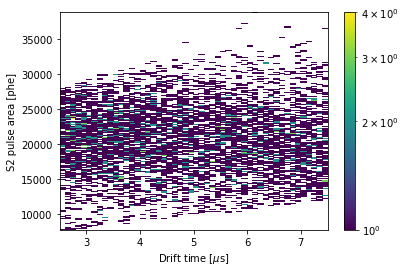

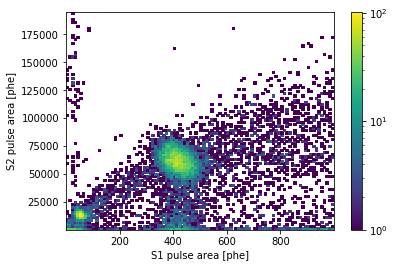

In [22]:
## Put your solution for problem 3 here.
# -- Perform the correction
cS2_array    = S2_array * np.exp(DT_array / exp_lifetime)
cTS2_array   = TS2_array * np.exp(DT_array / exp_lifetime)

n_bins_new = np.array([n_dt_bins, 1000])

# -- Create a 2D histogram of S2 vs depth
plt.figure(12)
plt.hist2d(DT_array[ROI_cut_indexer],cTS2_array[ROI_cut_indexer], bins=n_bins_new, norm=LogNorm())
plt.xlabel(r"Drift time [$\mu$s]")
plt.ylabel("S2 pulse area [phe]")
plt.colorbar()

# -- Create a 2D histogram of S2 vs S1
plt.figure(13)
plt.hist2d(S1_array[dt_cut_indexer],cS2_array[dt_cut_indexer], bins=n_s1s2_bins, norm=LogNorm())
plt.xlabel("S1 pulse area [phe]")
plt.ylabel("S2 pulse area [phe]")
plt.colorbar()